# Проект: предсказание продаж интернет-магазина

## Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи.   
Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

## Цель
Бизнес-цель начальная: предсказать вероятность покупки в течение 90 дней.

Далее:  
- roc-auc минимум 0.7,   
- построить confusion matrix,   
- переопределить бизнес-цель  
- перевыбрать метрику под новую бизнес-цель: precision, recall  

## Задачи
- Изучить данные
- Разработать полезные признаки
- Выбрать все модели, которые предсказывают бинарную классификацию
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование
- Создать: 
    - тетрадь jupyter notebook с описанием, подготовкой признаков, обучением модели и тестированием
    - описание проекта и инструкция по использованию в файле README.md
    - список зависимостей в файле requirements.txt

## Описание данных
`apparel-purchases.csv` (история покупок):  

Данные о покупках клиентов по дням и по товарам. 
В каждой записи покупка определенного товара, его цена, количество штук.  
В таблице есть списки идентификаторов, к каким категориям относится товар.   
Часто это вложенные категории (например автотовары-аксессуары-освежители),   
но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.  

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория.   
Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].   
Как обработать такие случаи – можете предлагать свои варианты решения.  

- `client_id` идентификатор пользователя  
- `quantity` количество товаров в заказе  
- `price` цена товара  
- `category_ids` вложенные категории, к которым отнсится товар  
- `date` дата покупки  
- `message_id` идентификатор сообщения из рассылки  

`apparel-messages.csv` (история рекламных рассылок):  

Рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` идентификатор рекламной кампании  
- `client_id` идентификатор пользователя  
- `message_id` идентификатор сообщений  
- `event` тип действия  
- `channel` канал рассылки  
- `date` дата рассылки  
- `created_at` точное время создания сообщения  

`apparel-target_binary.csv` (совершит ли клиент покупку в течение следующих 90 дней):  
- `client_id` идентификатор пользователя  
- `target` клиент совершил покупку в целевом периоде (целевой признак)  
<!-- 
`full_campaign_daily_event.csv` (агрегация общей базы рассылок по дням и типам событий):  

Общая база рассылок огромна, поэтому собрали для вас агрегированную по дням  
статистику по рассылкам. Если будете создавать на основе этой статистики дополнительные  
признаки, обратите внимание, что нельзя суммировать по колонкам nunique, потому что это  
уникальные клиенты в пределах дня, у вас нет данных, повторяются ли они в другие дни  

- `date` дата
- `bulk_campaign_id` идентификатор рассылки
- `count_event`* общее количество каждого события event
- `nunique_event`* количество уникальных client_id в каждом событии  
*в именах колонок есть все типы событий event

`full_campaign_daily_event_channel.csv` (агрегация по дням с учетом событий и каналов рассылки):  
- `date` дата
- `bulk_campaign_id` идентификатор рассылки
- `count_event`*_channel* общее количество каждого события по каналам
- `nunique_event`*_channel* количество уникальных client_id по событиям и каналам   
_в именах колонок есть все типы событий event и каналов рассылки channel -->

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# другие
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# оформление
pd.set_option('display.max_columns', None)

In [2]:
# константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка, предобработка и исследование данных

In [3]:
%%time

# грузим данные
df_purchases = pd.read_csv(r'data\apparel-purchases.csv')
df_messages = pd.read_csv(r'data\apparel-messages.csv')
df_target = pd.read_csv(r'data\apparel-target_binary.csv')
# df_campaign = pd.read_csv(r'data\full_campaign_daily_event.csv')
# df_campaign_channel = pd.read_csv(r'data\full_campaign_daily_event_channel.csv')

# делаем словарь
data_dict = {
    'df_purchases': df_purchases,
    'df_messages': df_messages,
    'df_target': df_target,
    # 'df_campaign': df_campaign,
    # 'df_campaign_channel': df_campaign_channel
}

# смотрим на данные
for name, df in data_dict.items():
    print('-'*120, name)
    df.info()
    display(df.describe(include='all'))
    display(df.head())

------------------------------------------------------------------------------------------------------------------------ df_purchases
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
count,2.022080e+05,202208.000000,202208.000000,202208,202208,202208
unique,NaN,NaN,NaN,933,642,50204
top,NaN,NaN,NaN,"['4', '28', '57', '431']",2022-11-11,1515915625489095763-6251-6311b13a4cf78
freq,NaN,NaN,NaN,8626,5270,365
mean,1.515916e+18,1.006483,1193.301516,NaN,NaN,NaN
std,1.459458e+08,0.184384,1342.252664,NaN,NaN,NaN
min,1.515916e+18,1.000000,1.000000,NaN,NaN,NaN
25%,1.515916e+18,1.000000,352.000000,NaN,NaN,NaN
50%,1.515916e+18,1.000000,987.000000,NaN,NaN,NaN
75%,1.515916e+18,1.000000,1699.000000,NaN,NaN,NaN


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


------------------------------------------------------------------------------------------------------------------------ df_messages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798,12739798,12739798,12739798
unique,NaN,NaN,9061667,11,2,638,4103539
top,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,2023-06-10,2023-12-29 15:20:53
freq,NaN,NaN,1454,9058196,7512156,89661,621
mean,1.160459e+04,1.515916e+18,NaN,NaN,NaN,NaN,NaN
std,3.259211e+03,1.329704e+08,NaN,NaN,NaN,NaN,NaN
min,5.480000e+02,1.515916e+18,NaN,NaN,NaN,NaN,NaN
25%,8.746000e+03,1.515916e+18,NaN,NaN,NaN,NaN,NaN
50%,1.351600e+04,1.515916e+18,NaN,NaN,NaN,NaN,NaN
75%,1.415800e+04,1.515916e+18,NaN,NaN,NaN,NaN,NaN


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


------------------------------------------------------------------------------------------------------------------------ df_target
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


CPU times: total: 25.4 s
Wall time: 25.5 s


Выводы:
- Purchases
    - id сделать строкой (и проверить нет ли случаев, когда разная длина строки, вдруг нули обрубились в начале)
    - date перевести в формат даты
- Messages
    - id сделать строкой (и проверить нет ли случаев, когда разная длина строки, вдруг нули обрубились в начале)
    - столбцы дат перевести в формат даты
- Target
    - id сделать строкой (и проверить нет ли случаев, когда разная длина строки, вдруг нули обрубились в начале)
<!-- - Campaign Events
    - id сделать строкой (и проверить нет ли случаев, когда разная длина строки, вдруг нули обрубились в начале)
    - date перевести в формат даты
- Campaign Events by Channel
    - id сделать строкой (и проверить нет ли случаев, когда разная длина строки, вдруг нули обрубились в начале)
    - date перевести в формат даты -->


In [4]:
# проверка на неяывные дубликаты
for name, df in data_dict.items():
    print(f'{name}:', end='\n')

    for col in df.columns:
        if col.endswith('_id'):
            df[col] = df[col].astype(str)
            print(f'{df[col].str.len().value_counts().to_string()}', end='\n\n')
        if col in ['date','created_at']:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    for col in df.select_dtypes('object').columns:
        if not col.endswith('_id') and not col.endswith('_ids'):
            print(f'Уникальные значения в столбце {col}: \n{sorted(df[col].unique())}', end='\n\n')


df_purchases:
client_id
19    202208

message_id
39    116465
38     85721
37        22

df_messages:
bulk_campaign_id
5    8768121
4    3971550
3        127

client_id
19    12739798

message_id
39    8768134
38    3971537
37        127

Уникальные значения в столбце event: 
['click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe']

Уникальные значения в столбце channel: 
['email', 'mobile_push']

df_target:
client_id
19    49849



Кажется, что идентификатор рекламной кампании не всегда должен быть одного формата,   
т.к. в теории им могли просто порядковые номера исторической последовательности присваивать,  
а идентификатор сообщения это комбинация айди клиента, айди кампании и строкове значение,   
поэтому вполне логично, что если значения айди маркетинговой кампании на один меньше,   
то и строки с айди сообещния будут с разницей в такое же количество символов.

В идеале этот момент уточнить у источника данных, а в рамках этого исследования мы это опустим и пойдем дальше. 

Сейчас займемся поиском пропусков и дубликатов:

In [5]:
# проверим на пропуски
for name, df in data_dict.items():
    if df.isna().any().any() or df.isnull().any().any():
        print('-'*120, name)
        display(df[df.isna().any(axis=1) | df.isnull().any(axis=1)].head())
    else:
        print(f'{name}: пропусков нет')

df_purchases: пропусков нет
df_messages: пропусков нет
df_target: пропусков нет


In [6]:
%%time

# проверим на дубликаты
for name, df in data_dict.items():
    if df.duplicated().any():
        print(f'{name}: {df.duplicated().sum()} дубликатов ({df.duplicated().sum() / len(df) * 100:.2f}% от общего количества строк)', end='\n\n')
        display(df[df.duplicated(keep=False)].head(2))
        print()
    else:
        print(f'{name}: дубликатов нет')

df_purchases: 73020 дубликатов (36.11% от общего количества строк)



,client_id,quantity,price,category_ids,date,message_id
11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f



df_messages: 48610 дубликатов (0.38% от общего количества строк)



,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56



df_target: дубликатов нет
CPU times: total: 39.8 s
Wall time: 39.8 s


В файле сообщений таких строк менее 1%, их можно смело удалить:

In [7]:
%%time

# удаляем дубликаты
df_messages.drop_duplicates(inplace=True)
df_messages.reset_index(drop=True, inplace=True)

# снова проверим на дубликаты
for name, df in data_dict.items():
    if name == 'df_messages':
        if df.duplicated().any():
            print(f'{name}: {df.duplicated().sum()} дубликатов ({df.duplicated().sum() / len(df) * 100:.2f}% от общего количества строк)')
            display(df[df.duplicated(keep=False)].head(2))
        else:
            print(f'{name}: дубликатов нет')

df_messages: дубликатов нет
CPU times: total: 20.4 s
Wall time: 20.5 s


А вот в файле с покупками их количество составляет треть от всего количества строк.  
Если есть возможность, следует сперва уточнить у источника данных, почему так много дублей.  
Т.к. дубликатов слишком много, это кажется подозрительным, попробуем сперва посмотреть на распределение количества товаров в заказе.  
Возможно часть таких "дублей" это один и тот же товар заказанный n-ое кол-во раз одним пользователем по одной штуке   
(например, ошибся с размером или почитал отзывы про "маломерки" и взял ещё несколько). 

## Исследование данных

Посмотрим на распределения данных ключевых признаков:

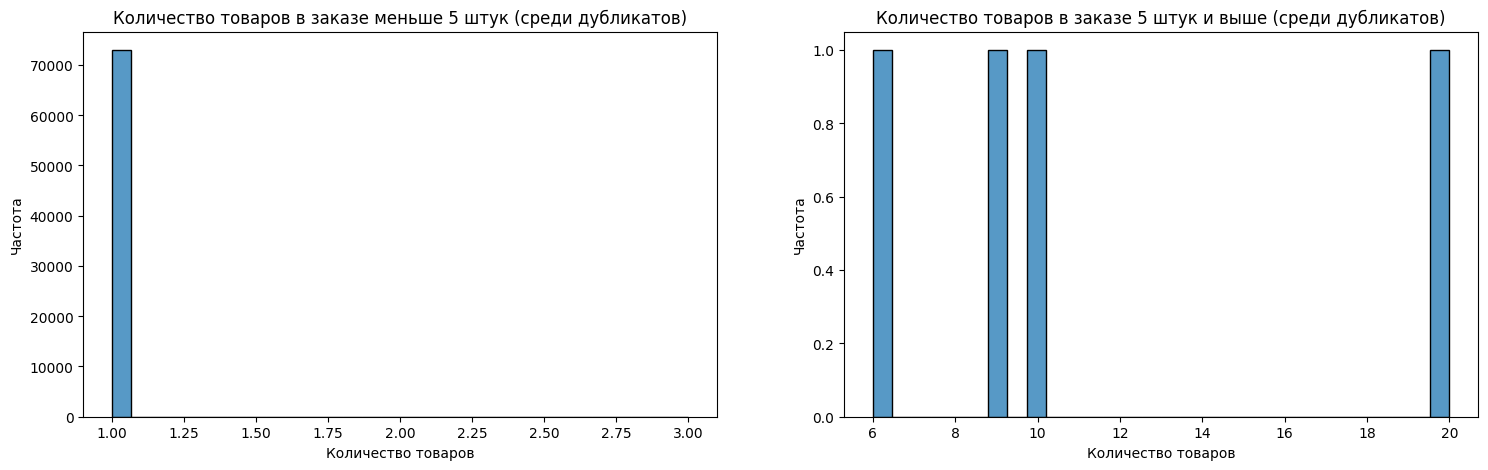

In [8]:
# делаем временный дф с условием
dups = df_purchases[df_purchases.duplicated()].copy()

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18,5))

sns.histplot(dups[dups['quantity'] < 5]['quantity'], bins=30, ax=axes[0])
axes[0].set_title('Количество товаров в заказе меньше 5 штук (среди дубликатов)')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Количество товаров')

sns.histplot(dups[dups['quantity'] >= 5]['quantity'], bins=30, ax=axes[1])
axes[1].set_title('Количество товаров в заказе 5 штук и выше (среди дубликатов)')
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Количество товаров')
plt.show()

Построим такой же график, но для всего датафрейма, чтобы сравнить распределения:

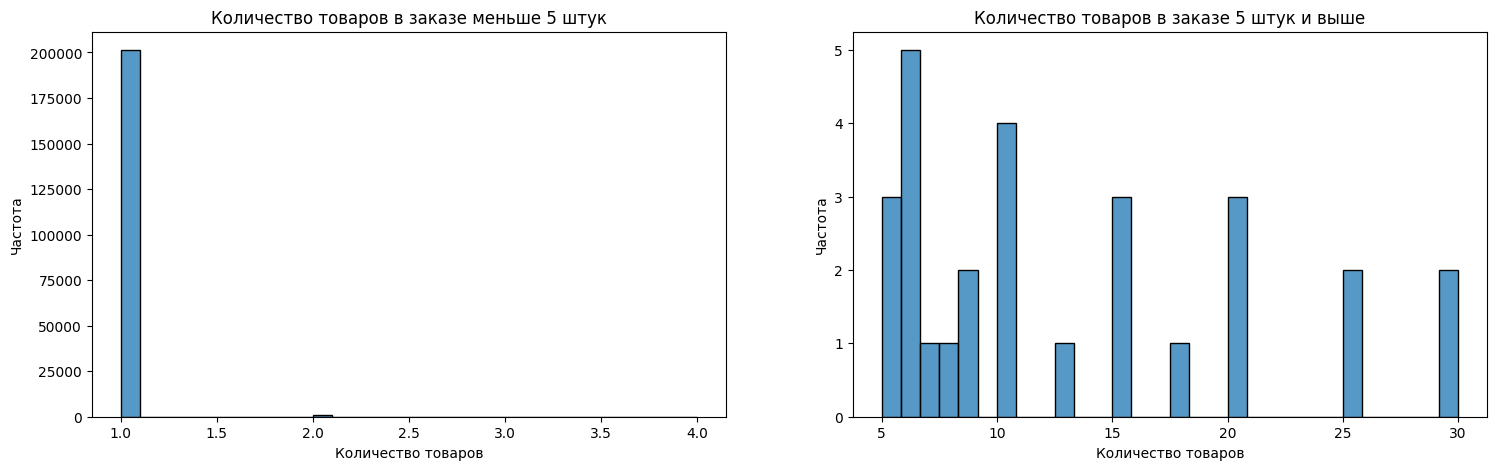

In [9]:
# такой же график, но для всего датафрейма
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18,5))

sns.histplot(df_purchases[df_purchases['quantity'] < 5]['quantity'], bins=30, ax=axes[0])
axes[0].set_title('Количество товаров в заказе меньше 5 штук')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Количество товаров')

sns.histplot(df_purchases[df_purchases['quantity'] >= 5]['quantity'], bins=30, ax=axes[1])
axes[1].set_title('Количество товаров в заказе 5 штук и выше')
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Количество товаров')
plt.show()

В целом распределения похожи и большая часть товаров заказана по одной штуке, что подтверждает догадку о том,   
что в файле покупок это скорее всего не дубли, а повторные заказы по одной штуке товара. Поэтому удалять эти строки мы не будем.

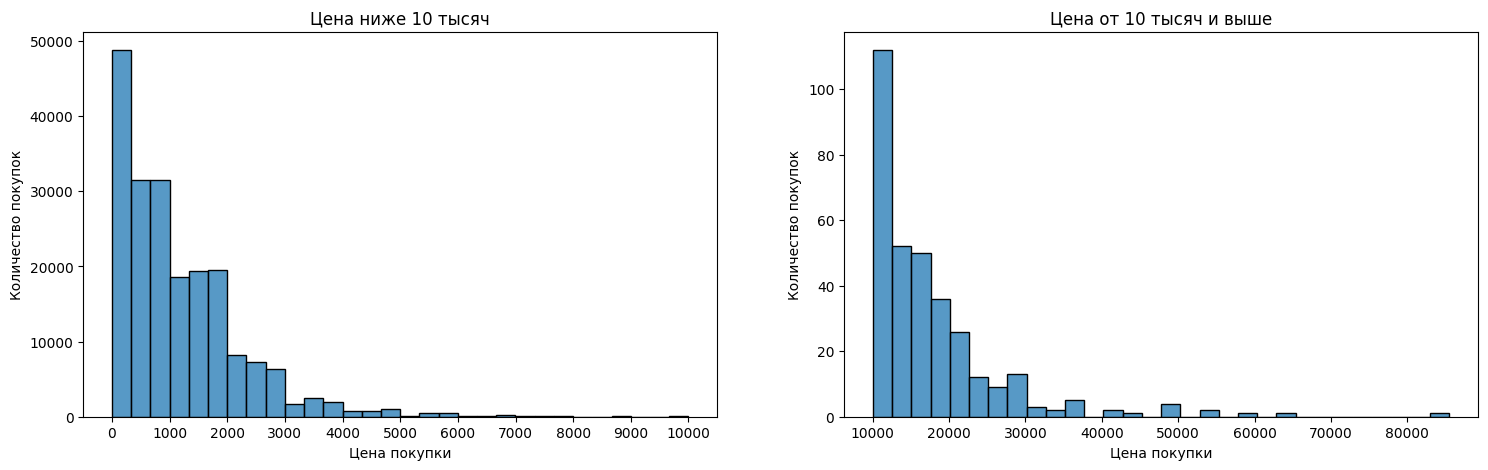

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18,5))

sns.histplot(df_purchases[df_purchases['price'] < 10000]['price'], bins=30, ax=axes[0])
axes[0].set_xticks(range(0, 11000, 1000))
axes[0].set_title('Цена ниже 10 тысяч')
axes[0].set_ylabel('Количество покупок')
axes[0].set_xlabel('Цена покупки')

sns.histplot(df_purchases[df_purchases['price'] >= 10000]['price'], bins=30, ax=axes[1])
axes[1].set_title('Цена от 10 тысяч и выше')
axes[1].set_ylabel('Количество покупок')
axes[1].set_xlabel('Цена покупки')
plt.show()

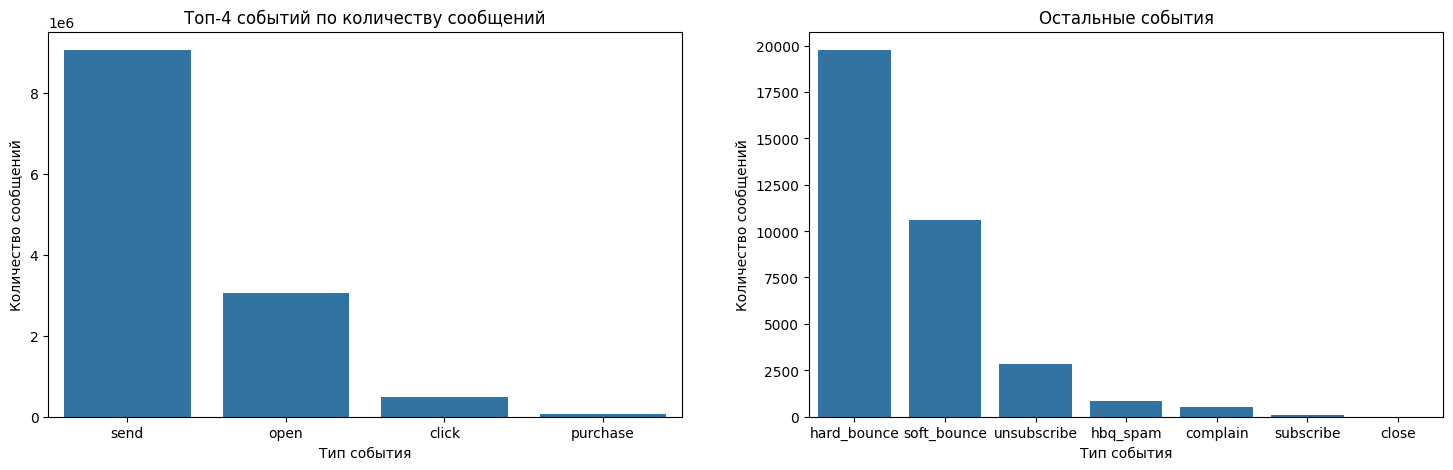

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18,5))

sns.barplot(x=df_messages['event'].value_counts().iloc[:4].index, 
            y=df_messages['event'].value_counts().iloc[:4].values, ax=axes[0])
axes[0].set_title('Топ-4 событий по количеству сообщений')
axes[0].set_ylabel('Количество сообщений')
axes[0].set_xlabel('Тип события')

sns.barplot(x=df_messages['event'].value_counts().iloc[4:].index, 
            y=df_messages['event'].value_counts().iloc[4:].values, ax=axes[1])
axes[1].set_title('Остальные события')
axes[1].set_ylabel('Количество сообщений')
axes[1].set_xlabel('Тип события')
plt.show()

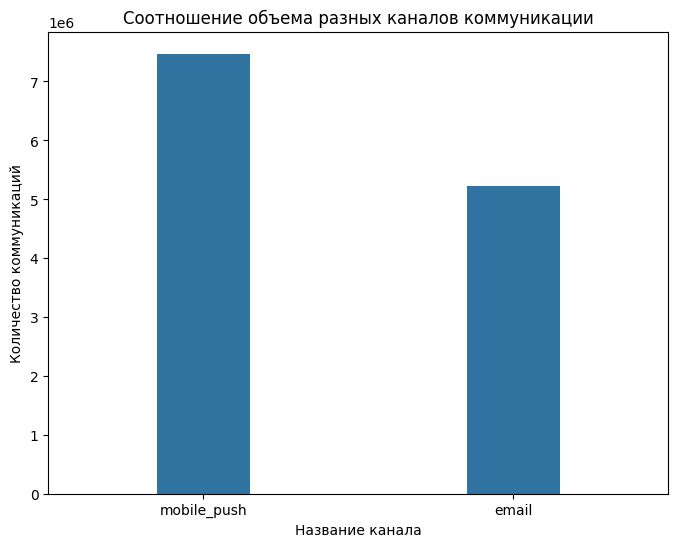

In [12]:
plt.figure(figsize=(8,6))
sns.barplot(x=df_messages['channel'].value_counts().index, 
            y=df_messages['channel'].value_counts().values,
            width=0.3)
plt.title('Соотношение объема разных каналов коммуникации')
plt.ylabel('Количество коммуникаций')
plt.xlabel('Название канала')
plt.show()

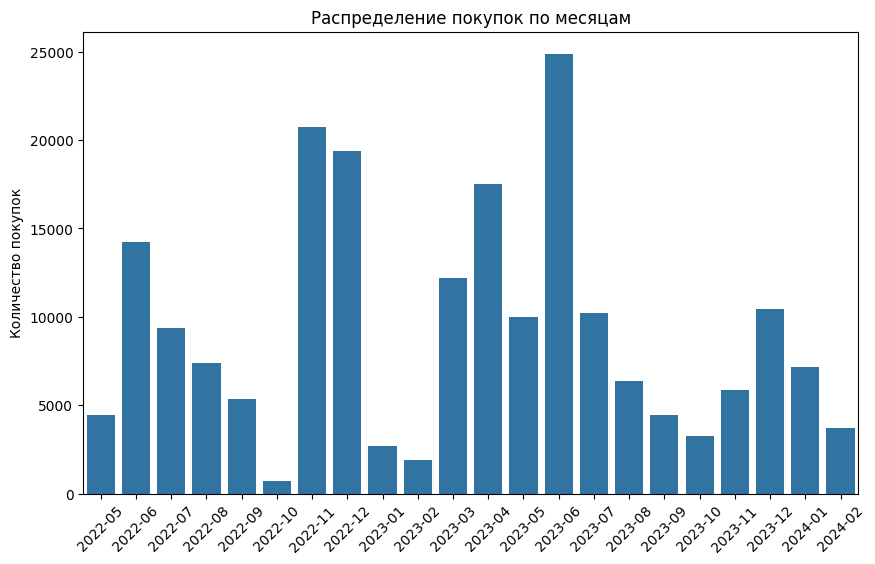

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_purchases['date'].dt.strftime("%Y-%m").value_counts().sort_index().index,
            y=df_purchases['date'].dt.strftime("%Y-%m").value_counts().sort_index().values)
plt.xticks(rotation=45)
plt.title('Распределение покупок по месяцам')
plt.ylabel('Количество покупок')
plt.xlabel('')
plt.show()

Есть ощущение, что в 2022 в ноябре и декабре были успешные промоакции, т.к. в 2023 пики сильно меньше.  
В целом прослеживается сезонность с первым пиком в начале лета и вторым, поменьше, в ноябре-декабре. 

Посмтроим более подробный график:

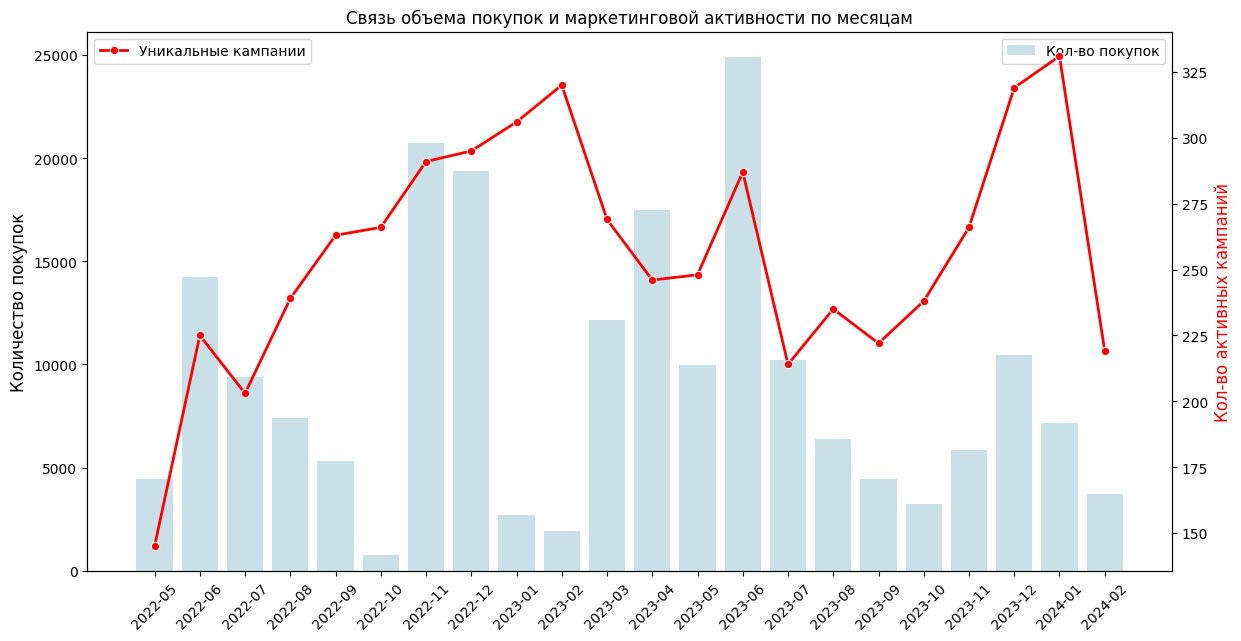

In [14]:
# создаем столбцы год-месяц
df_purchases['month'] = df_purchases['date'].dt.to_period('M')
df_messages['month'] = df_messages['date'].dt.to_period('M')

# агрегируем покупки
monthly_purchases = df_purchases.groupby('month').size()

# агрегируем кампании: количество уникальных кампаний и общее число отправленных сообщений
monthly_campaigns = df_messages.groupby('month').agg(
    unique_campaigns=('bulk_campaign_id', 'nunique'),
    total_messages=('message_id', 'count')
)

fig, ax1 = plt.subplots(figsize=(14, 7))

# график покупок (столбцы)
sns.barplot(x=monthly_purchases.index.astype(str), y=monthly_purchases.values, 
            ax=ax1, color='lightblue', label='Кол-во покупок', alpha=0.7)
ax1.set_ylabel('Количество покупок', fontsize=12)
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)

# создаем вторую ось Y для линии кампаний
ax2 = ax1.twinx()
sns.lineplot(x=monthly_campaigns.index.astype(str), y=monthly_campaigns['unique_campaigns'], 
             ax=ax2, color='red', marker='o', linewidth=2, label='Уникальные кампании')
ax2.set_ylabel('Кол-во активных кампаний', color='red', fontsize=12)

plt.title('Связь объема покупок и маркетинговой активности по месяцам')
plt.show()

Судя по графику, маркетинговые акции в ноябре-декабре 2022 года были очень плодотворными, а логичное их увеличение спустя год не дало ожидаемого результата.  
Возможно из-за того, что начали прогрев слишком поздно, а может наложились внешние факторы (кризис, инфляция и т.п.)

In [15]:
print('Посмотрим на соотношение классов целевой переменной:')
print(df_target['target'].value_counts(normalize=True))

Посмотрим на соотношение классов целевой переменной:
target
0    0.980722
1    0.019278
Name: proportion, dtype: float64


На лицо сильный дисбаланас классов, который необходимо учитывать при обучении модели.

## Инжиниринг признаков
Начнем агрегацию признаков по client_id, чтобы уменьшить объем данных и получить возможность строить предсказания покупки для каждого клиента:

In [17]:
# разработаем признаки для данных покупок
last_date = df_purchases['date'].max()

features_purchases = df_purchases.groupby('client_id').agg(
    recency=('date', lambda x: (last_date - x.max()).days),
    freq=('date', 'count'),
    sum_price=('price', 'sum'),
    mean_price=('price', 'mean'),
    max_price=('price', 'max'),
    sum_quant=('quantity', 'sum')
).reset_index()

# разработаем признаки для данных сообщений
features_messages = df_messages.pivot_table(
    index='client_id', 
    columns='event', 
    values='message_id', 
    aggfunc='count', 
    fill_value=0
).reset_index()

# добавим метрики CTR и Open Rate
features_messages['open_rate'] = features_messages['open'] / features_messages['send'].replace(0, 1) # защита от деления на ноль
features_messages['click_rate'] = features_messages['click'] / features_messages['send'].replace(0, 1) # защита от деления на ноль

# объединим датафреймы
df_full = df_target.merge(features_purchases, on='client_id', how='left')
df_full = df_full.merge(features_messages, on='client_id', how='left')

# заполняем пропуски нулями (если не было покупок/сообщений в логах)
df_full = df_full.fillna(0)

# посмотрим что получилось
print('features_purchases:')
print(f'Количество строк уменьшилось на {-(features_purchases.shape[0] / df_purchases.shape[0] - 1) * 100:.2f} %')
print(f'Было {df_purchases.shape[0]} строк, стало {features_purchases.shape[0]}')
display(features_purchases.head())

print('features_messages:')
print(f'Количество строк уменьшилось на {-(features_messages.shape[0] / df_messages.shape[0] - 1) * 100:.2f} %')
print(f'Было {df_messages.shape[0]} строк, стало {features_messages.shape[0]}')
display(features_messages.head())

print('df_full:')
print(f'Количество строк уменьшилось на {-(df_full.shape[0] / df_messages.shape[0] - 1) * 100:.2f} %')
print(f'Было {df_messages.shape[0]} строк, стало {df_full.shape[0]}')
display(df_full.head())

features_purchases:
Количество строк уменьшилось на 75.35 %
Было 202208 строк, стало 49849


,client_id,recency,freq,sum_price,mean_price,max_price,sum_quant
0,1515915625468060902,630,7,6993.0,999.000000,1999.0,7
1,1515915625468061003,408,7,16235.0,2319.285714,3499.0,7
2,1515915625468061099,640,1,299.0,299.000000,299.0,1
3,1515915625468061100,6,2,2098.0,1049.000000,1049.0,2
4,1515915625468061170,244,19,33601.0,1768.473684,2699.0,19


features_messages:
Количество строк уменьшилось на 99.58 %
Было 12691188 строк, стало 53329


event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,open_rate,click_rate
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1,0.277778,0.079365
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0,0.032468,0.032468
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0,0.237209,0.037209
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0,0.588015,0.003745
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0,0.127572,0.065844


df_full:
Количество строк уменьшилось на 99.61 %
Было 12691188 строк, стало 49849


,client_id,target,recency,freq,sum_price,mean_price,max_price,sum_quant,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,open_rate,click_rate
0,1515915625468060902,0,630,7,6993.0,999.000000,1999.0,7,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,0.277778,0.079365
1,1515915625468061003,1,408,7,16235.0,2319.285714,3499.0,7,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,0.032468,0.032468
2,1515915625468061099,0,640,1,299.0,299.000000,299.0,1,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,0.237209,0.037209
3,1515915625468061100,0,6,2,2098.0,1049.000000,1049.0,2,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,0.588015,0.003745
4,1515915625468061170,0,244,19,33601.0,1768.473684,2699.0,19,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,0.127572,0.065844


Можно заметить, что строк после агрегации в датафрейме с сообщениями больше, а значит клиентов там больше, проверим это:

In [18]:
missed_clients = df_messages[~df_messages['client_id'].isin(df_purchases['client_id'])]

print('Количество клиентов, которых нет в файле с покупками:', missed_clients['client_id'].nunique())

Количество клиентов, которых нет в файле с покупками: 11347


Возможно эти клиенты ничего не купили и поэтому их нет в датафрейме с покупками?  
Давайте это проверим:

In [19]:
missed_clients[missed_clients['event'] == 'purchase']

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,month
9686,4463,1515915625762574052,1515915625762574052-4463-6285e40cf2e9d,purchase,email,2022-05-19,2022-05-19 09:29:50,2022-05
9818,4463,1515915625762574052,1515915625762574052-4463-6285e40cf2e9d,purchase,email,2022-05-19,2022-05-19 10:07:35,2022-05
16539,4463,1515915625575226281,1515915625575226281-4463-6285e403f19a9,purchase,email,2022-05-19,2022-05-19 14:21:29,2022-05
16668,4463,1515915625468098869,1515915625468098869-4463-6285e40a7b3a3,purchase,email,2022-05-19,2022-05-19 15:36:36,2022-05
16754,4463,1515915625489136208,1515915625489136208-4463-6285e403e5023,purchase,email,2022-05-19,2022-05-19 16:27:00,2022-05
...,...,...,...,...,...,...,...,...
12619182,14641,1515915625491260726,1515915625491260726-14641-65cb23e6e99fc,purchase,email,2024-02-14,2024-02-14 11:17:16,2024-02
12623869,14624,1515915625559943797,1515915625559943797-14624-65c5e1e6e7eee,purchase,email,2024-02-14,2024-02-14 11:55:16,2024-02
12630469,14624,1515915625566605932,1515915625566605932-14624-65c5e2591dd3b,purchase,email,2024-02-14,2024-02-14 12:29:16,2024-02
12651301,14624,1515915625489389564,1515915625489389564-14624-65c5e2639975d,purchase,email,2024-02-15,2024-02-15 06:11:58,2024-02


Как мы видим, больше половины клиентов, которых мы не нашли в файле с продажами, на самом деле совершили покупку.  
Думаю следует отдать эти случаи команде, которая формировала исходные данные, чтобы они проверили почему так вышло.

## Обучение модели
Разработаем модель, которая будет предсказывать вероятность покупки в течение 90 дней.  

Для этого мы сперва запустим базовые модели и модели с бустингом без перебора гиперпараметров,   
чтобы посмотреть кто базово лучше всего справляется, а затем сделаем перебор гиперпараметров у финалиста.  

Отбирать будем по наивысшему показателю метрики ROC AUC.

In [20]:
%%time

# убираем client_id в индекс
df_full.set_index('client_id', inplace=True)

X = df_full.drop(['target'], axis=1)
y = df_full['target']

# добавляем стратификацию, т.к. сильный дисбаланс классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y) 

# масштабируем признаки для LogReg и KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200, class_weight='balanced'),

    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
}

results = []

for name, model in models.items():
    # для LogReg и KNN используем масштабированные данные
    if name in ['Logistic Regression', 'KNN']:
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, probs)
    results.append({'Model': name, 'ROC-AUC': round(auc, 3)})

# вывод результатов
df_results = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
df_results

CPU times: total: 1min 4s
Wall time: 10.9 s


,Model,ROC-AUC
0,Logistic Regression,0.737
6,LightGBM,0.736
5,CatBoost,0.727
2,Decision Tree,0.708
3,Random Forest,0.686
4,XGBoost,0.685
1,KNN,0.547


Как мы видим лучше всего справилась самая базовая модель, попробуем перебрать её гиперпараметры, чтобы улучшить качество:

In [21]:
%%time

# список параметров для логистической регрессии
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # степень регуляризации: чем меньше, тем меньше переобучение, чем выше, тем больше модель подстраивается под данные
    'penalty': ['l1', 'l2'], # тип регуляризации, l1 - зануляет бесполезные признаки, l2 - делает вес бесполезных оч маленьким, но все равно учитывает
    'solver': ['liblinear'] # в отличии от дефолтного движка учитывает l1 и l2 на малых выборках (~до 100к строк)
}

# т.к. модель быстрая, использовать будем обычный GridSearchCV
search = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

search.fit(X_train_scaled, y_train)

best_model = search.best_estimator_
print(f'Лучшие параметры: {search.best_params_}')
print(f'Лучший ROC-AUC на кросс-валидации: {search.best_score_:.3f}')

Лучшие параметры: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший ROC-AUC на кросс-валидации: 0.723
CPU times: total: 3.61 s
Wall time: 8.27 s


## Тестирование модели
Выполним тестирование лучшей модели, построим для неё confusion matrix и переопределим бизнес-цель на её основе,  
также выберем новую метрику, которая лучше всего подойдет под новую бизнес-цель (precision или recall). 

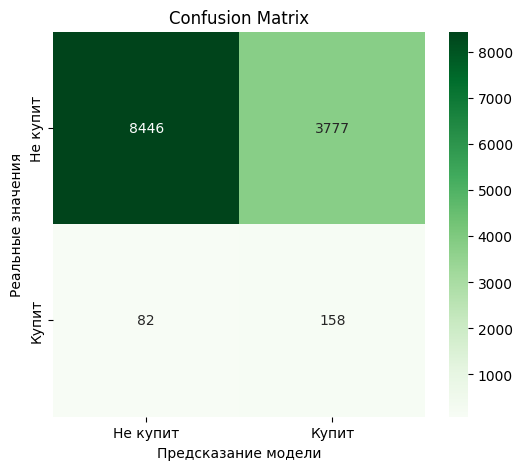

Отчет по метрикам:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     12223
           1       0.04      0.66      0.08       240

    accuracy                           0.69     12463
   macro avg       0.52      0.67      0.44     12463
weighted avg       0.97      0.69      0.80     12463

Итоговый ROC-AUC на тесте: 0.736


In [22]:
# предсказания
final_probs = best_model.predict_proba(X_test_scaled)[:, 1]
final_preds = best_model.predict(X_test_scaled)

# строим Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, final_preds), 
            annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Не купит', 'Купит'], 
            yticklabels=['Не купит', 'Купит'])
plt.title('Confusion Matrix')
plt.ylabel('Реальные значения')
plt.xlabel('Предсказание модели')
plt.show()

print('Отчет по метрикам:')
print(classification_report(y_test, final_preds))
print(f'Итоговый ROC-AUC на тесте: {roc_auc_score(y_test, final_probs):.3f}')

Очевидно, что для заказчика (магазин), важнее предсказывать тех, кто купит,   
поэтому выберем метрику Recall, которую попробуем улучшить с помощью изменения порога:

Метрики при пороге 0.3:
              precision    recall  f1-score   support

           0       0.99      0.22      0.35     12223
           1       0.02      0.94      0.04       240

    accuracy                           0.23     12463
   macro avg       0.51      0.58      0.20     12463
weighted avg       0.98      0.23      0.35     12463



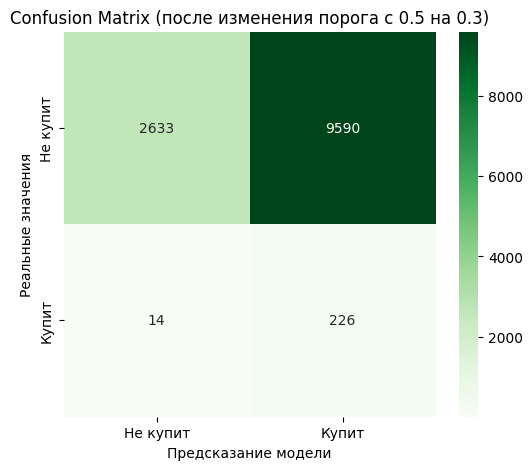

In [23]:
# меняем порог отсечения
new_preds = (final_probs >= 0.3).astype(int)

print('Метрики при пороге 0.3:')
print(classification_report(y_test, new_preds))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, new_preds), 
            annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Не купит', 'Купит'], 
            yticklabels=['Не купит', 'Купит'])
plt.title('Confusion Matrix (после изменения порога с 0.5 на 0.3)')
plt.ylabel('Реальные значения')
plt.xlabel('Предсказание модели')
plt.show()

# Вывод

Лучшей моделью оказалась логистическая регрессия с ROC-AUC ~0.74
Recall для класса покупки мы повысили с 0.66 до 0.94 с помощью изменения уменьшения порога.

Для запуска кампании рекомендуется использовать модель не с дефолтным порогом, а настроенным под стоимость коммуникации:       
при низкой стоимости контакта стоит занижать порог вероятности (как мы сделали ранее: с 0.5 до 0.3), чтобы увеличить охват (recall),  
при высокой найти оптимальное соотношение для цены покупки.